In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [1]:
def generate_two_gaussians(
    n1=10000, mean1=0, sigma1=1,
    n2=1000, mean2=100, sigma2=10,
    random_state=None
):
    """
    Generate a dataset composed of two Gaussian distributions.
    
    Parameters
    ----------
    n1 : int
        Number of samples in the first (tight) Gaussian.
    mean1 : float
        Mean of the first Gaussian.
    sigma1 : float
        Standard deviation of the first Gaussian.
    n2 : int
        Number of samples in the second (broad) Gaussian.
    mean2 : float
        Mean of the second Gaussian.
    sigma2 : float
        Standard deviation of the second Gaussian.
    random_state : int or None
        Seed for reproducibility.
        
    Returns
    -------
    data : np.ndarray
        Combined array of samples.
    labels : np.ndarray
        Array of labels (0 for first Gaussian, 1 for second).
    """
    rng = np.random.default_rng(random_state)
    
    g1 = rng.normal(mean1, sigma1, n1)
    g2 = rng.normal(mean2, sigma2, n2)
    
    data = np.concatenate([g1, g2])
    labels = np.concatenate([np.zeros(n1, dtype=int), np.ones(n2, dtype=int)])
    
    return data, labels


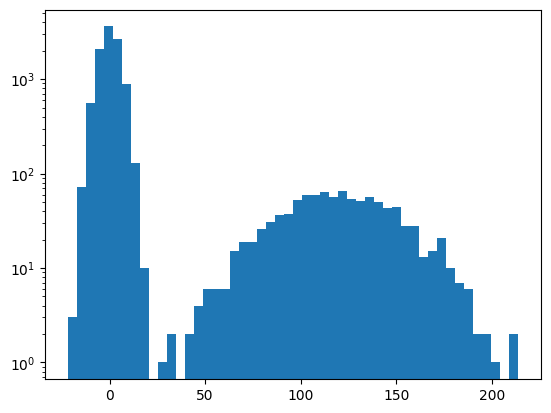

In [11]:
#generate data
data, labels = generate_two_gaussians(
    n1=10000, mean1=0, sigma1=5,
    n2=1000, mean2=120, sigma2=30,
    random_state=42
)

#plot data
counts, bin_edges,_ = plt.hist(data, bins = 50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.yscale("log")

## restricted fit to the curve

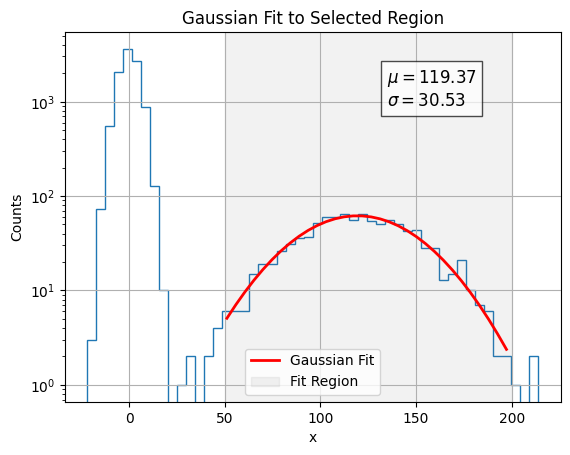

In [17]:
#gaussian function for scipy curve fit
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

#limits of the fitter (filter the data to just look at bins in the range 
fit_min, fit_max = 50, 200
region = (bin_centers >= fit_min) & (bin_centers <= fit_max)

x_fit = bin_centers[region]
y_fit = counts[region]

# ----------------------------------------
# 5. Fit the Gaussian only to that region
# ----------------------------------------

p0 = [100, 100, 20]   # initial guess: amplitude, mean, sigma
#the actual curve fitting happens here
params, cov = curve_fit(gaussian, x_fit, y_fit, bounds=(
        [0,  80,   0.1],   # lower bounds: A>0, mean>80, sigma>0.1
        [np.inf, 120, 50]  # upper bounds
    ),
    maxfev=20000, p0=p0)

A_fit, mu_fit, sigma_fit = params


#draw the histogram computed  above
plt.stairs(counts, bin_edges)
plt.plot(x_fit, gaussian(x_fit, *params), 'r-', linewidth=2, label="Gaussian Fit")
#draw the fit range
plt.axvspan(fit_min, fit_max, color="gray", alpha=0.1, label="Fit Region")
#draw mu and sigma on the plot
text = (
    rf"$\mu = {mu_fit:.2f}$" "\n"
    rf"$\sigma = {sigma_fit:.2f}$"
)
plt.text(0.65, 0.80, text,
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"))
plt.legend()
plt.xlabel("x")
plt.ylabel("Counts")
plt.title("Gaussian Fit to Selected Region")
plt.grid(True)
plt.yscale("log")
plt.show()


## correctly including the uncertainty on each bin in the fit
The chi-2 needs an uncertainty for each bin, for this data the uncertainty on the data is the sqrt of the number of counts in the bin, without it the fitter places too much importance on fitting bins with fewer counts in them and therefore larger uncertainties compared to bins with more counts and smaller uncertainties. 

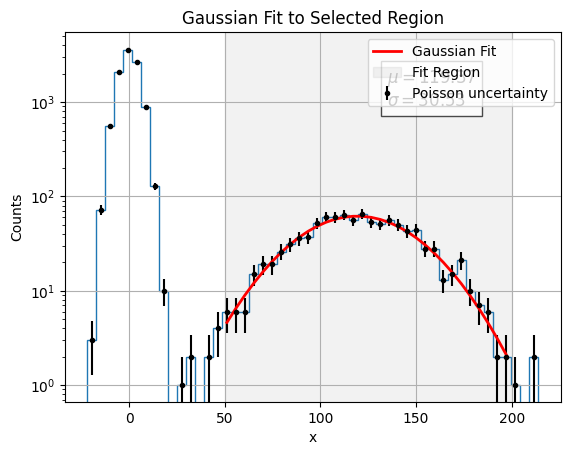

In [19]:

#limits of the fitter (filter the data to just look at bins in the range 
fit_min, fit_max = 50, 200
region = (bin_centers >= fit_min) & (bin_centers <= fit_max)

x_fit = bin_centers[region]
y_fit = counts[region]

# -----------------------------
# Poisson uncertainties: σ = sqrt(N)
# -----------------------------
## note that sigma here is not the gaussian width sigma but the statistical uncertainty on each bin
sigma_y = np.sqrt(y_fit)
sigma_y[sigma_y == 0] = 1.0   # avoid division by zero

params, cov = curve_fit(
    gaussian,
    x_fit,
    y_fit,
    p0=p0,
    sigma=sigma_y,
    absolute_sigma=True,
    bounds=([0, fit_min, 0.1], [np.inf, fit_max, 50]),
    maxfev=20000
)

#draw the histogram computed  above
plt.stairs(counts, bin_edges)
#draw the stiatistical uncertainty
yerr = np.sqrt(counts)
plt.errorbar(
    bin_centers,
    counts,
    yerr=yerr,
    fmt='o',
    color="black",
    markersize=3,
    label="Poisson uncertainty"
)

plt.plot(x_fit, gaussian(x_fit, *params), 'r-', linewidth=2, label="Gaussian Fit")
#draw the fit range
plt.axvspan(fit_min, fit_max, color="gray", alpha=0.1, label="Fit Region")
#draw mu and sigma on the plot
text = (
    rf"$\mu = {mu_fit:.2f}$" "\n"
    rf"$\sigma = {sigma_fit:.2f}$"
)
plt.text(0.65, 0.80, text,
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"))
plt.legend()
plt.xlabel("x")
plt.ylabel("Counts")
plt.title("Gaussian Fit to Selected Region")
plt.grid(True)
plt.yscale("log")
plt.show()